# Results Processing

## Imports and variables used throughout file

Load results dataframe from pickle file

In [9]:
from dir_paths import PROCESSED_DATA_DIR, FIGURES_SIMULATIONS_DIR, TABLES_DIR
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
import numpy as np

# Configure matplotlib to use LaTeX
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": [10, 6],
    "savefig.dpi": 300,
    "savefig.format": "pdf"
})

AXIS_FONT_SIZE = 14
TITLE_FONT_SIZE = 16
TICKS_FONT_SIZE = 14
LEGEND_FONT_SIZE = 14

# Define consistent colors for algorithms - more appealing palette
FIFO_COLOR = '#1f77b4'  # Professional blue
LRU_COLOR = '#ff7f0e'   # Vibrant orange  
SIEVE_COLOR = '#2ca02c'  # Fresh green

# Color mapping dictionary
ALGORITHM_COLORS = {
    'FIFO': FIFO_COLOR,
    'LRU': LRU_COLOR,
    'SIEVE': SIEVE_COLOR
}

# Load results_df from pickle file
results_df = pd.read_pickle(f"{PROCESSED_DATA_DIR}/results_df.pkl")

## Miss ratio vs. relative cache size

### Violin plots

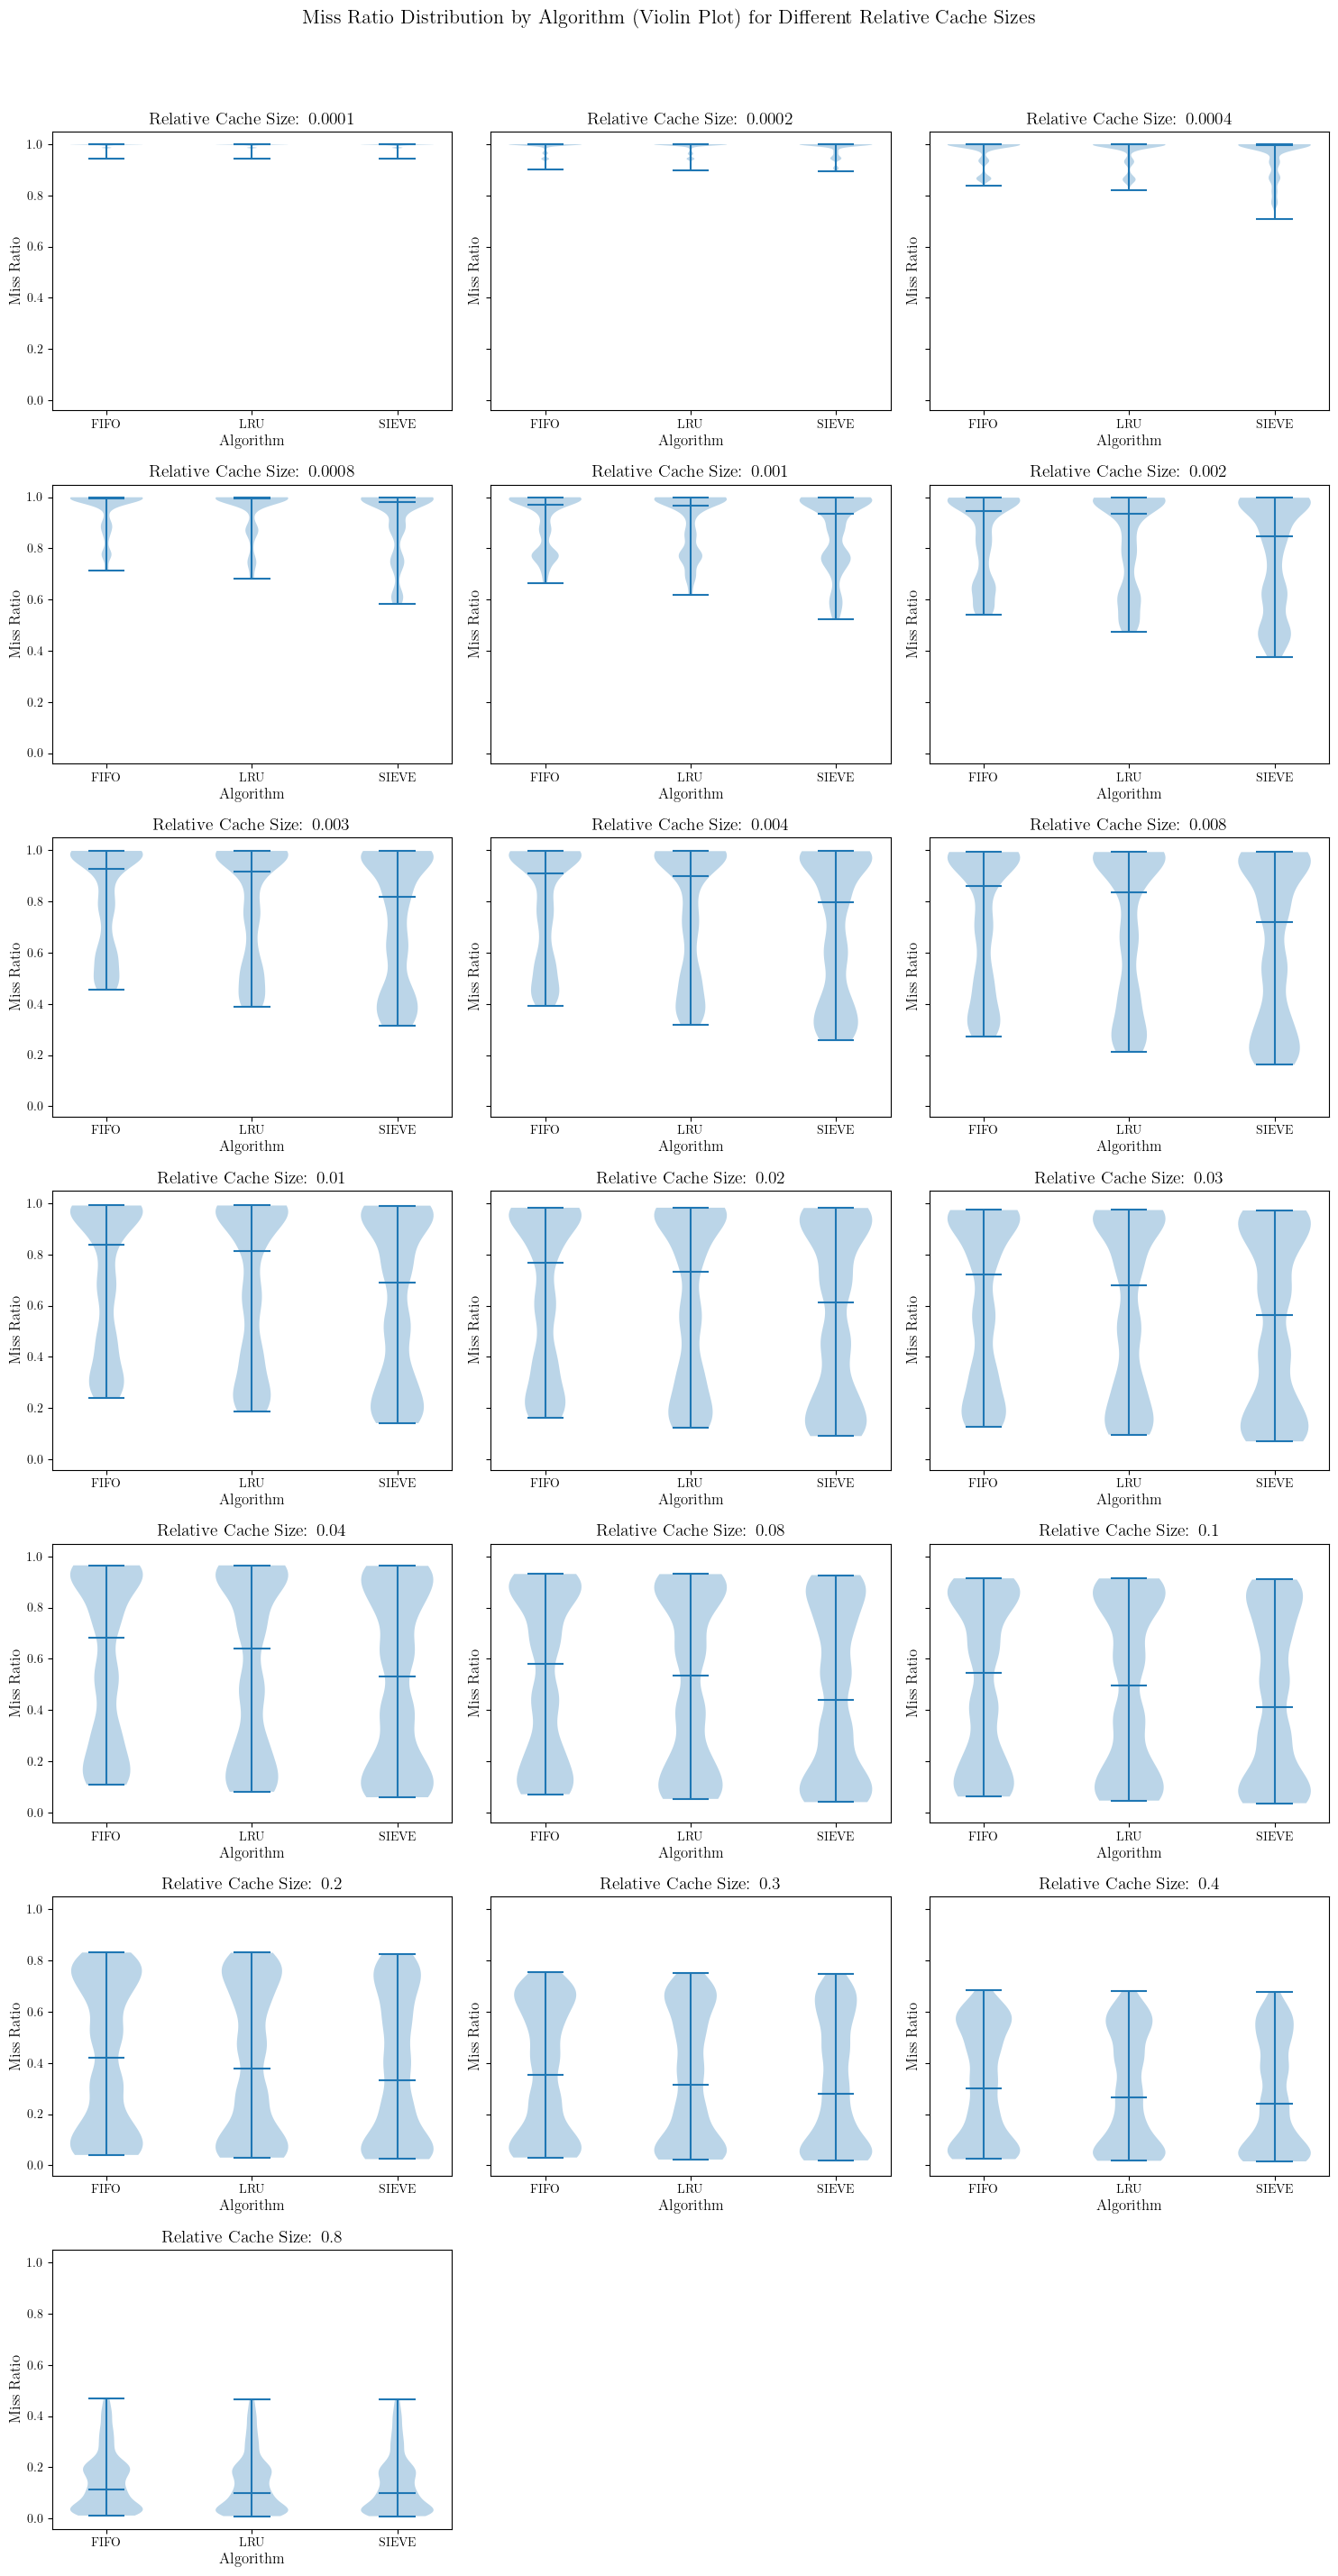

In [10]:
# Violin plots for miss ratio distribution by algorithm for each cache size
unique_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
n_sizes = len(unique_sizes)
n_cols = 3
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset_violin = [subset[subset['algorithm'] == algo]['miss_ratio'] for algo in subset['algorithm'].unique()]
    ax.violinplot(subset_violin, showmeans=False, showmedians=True)
    ax.set_xticks(range(1, len(subset['algorithm'].unique()) + 1))
    ax.set_xticklabels(subset['algorithm'].unique())
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm (Violin Plot) for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Boxplot per relative cache size

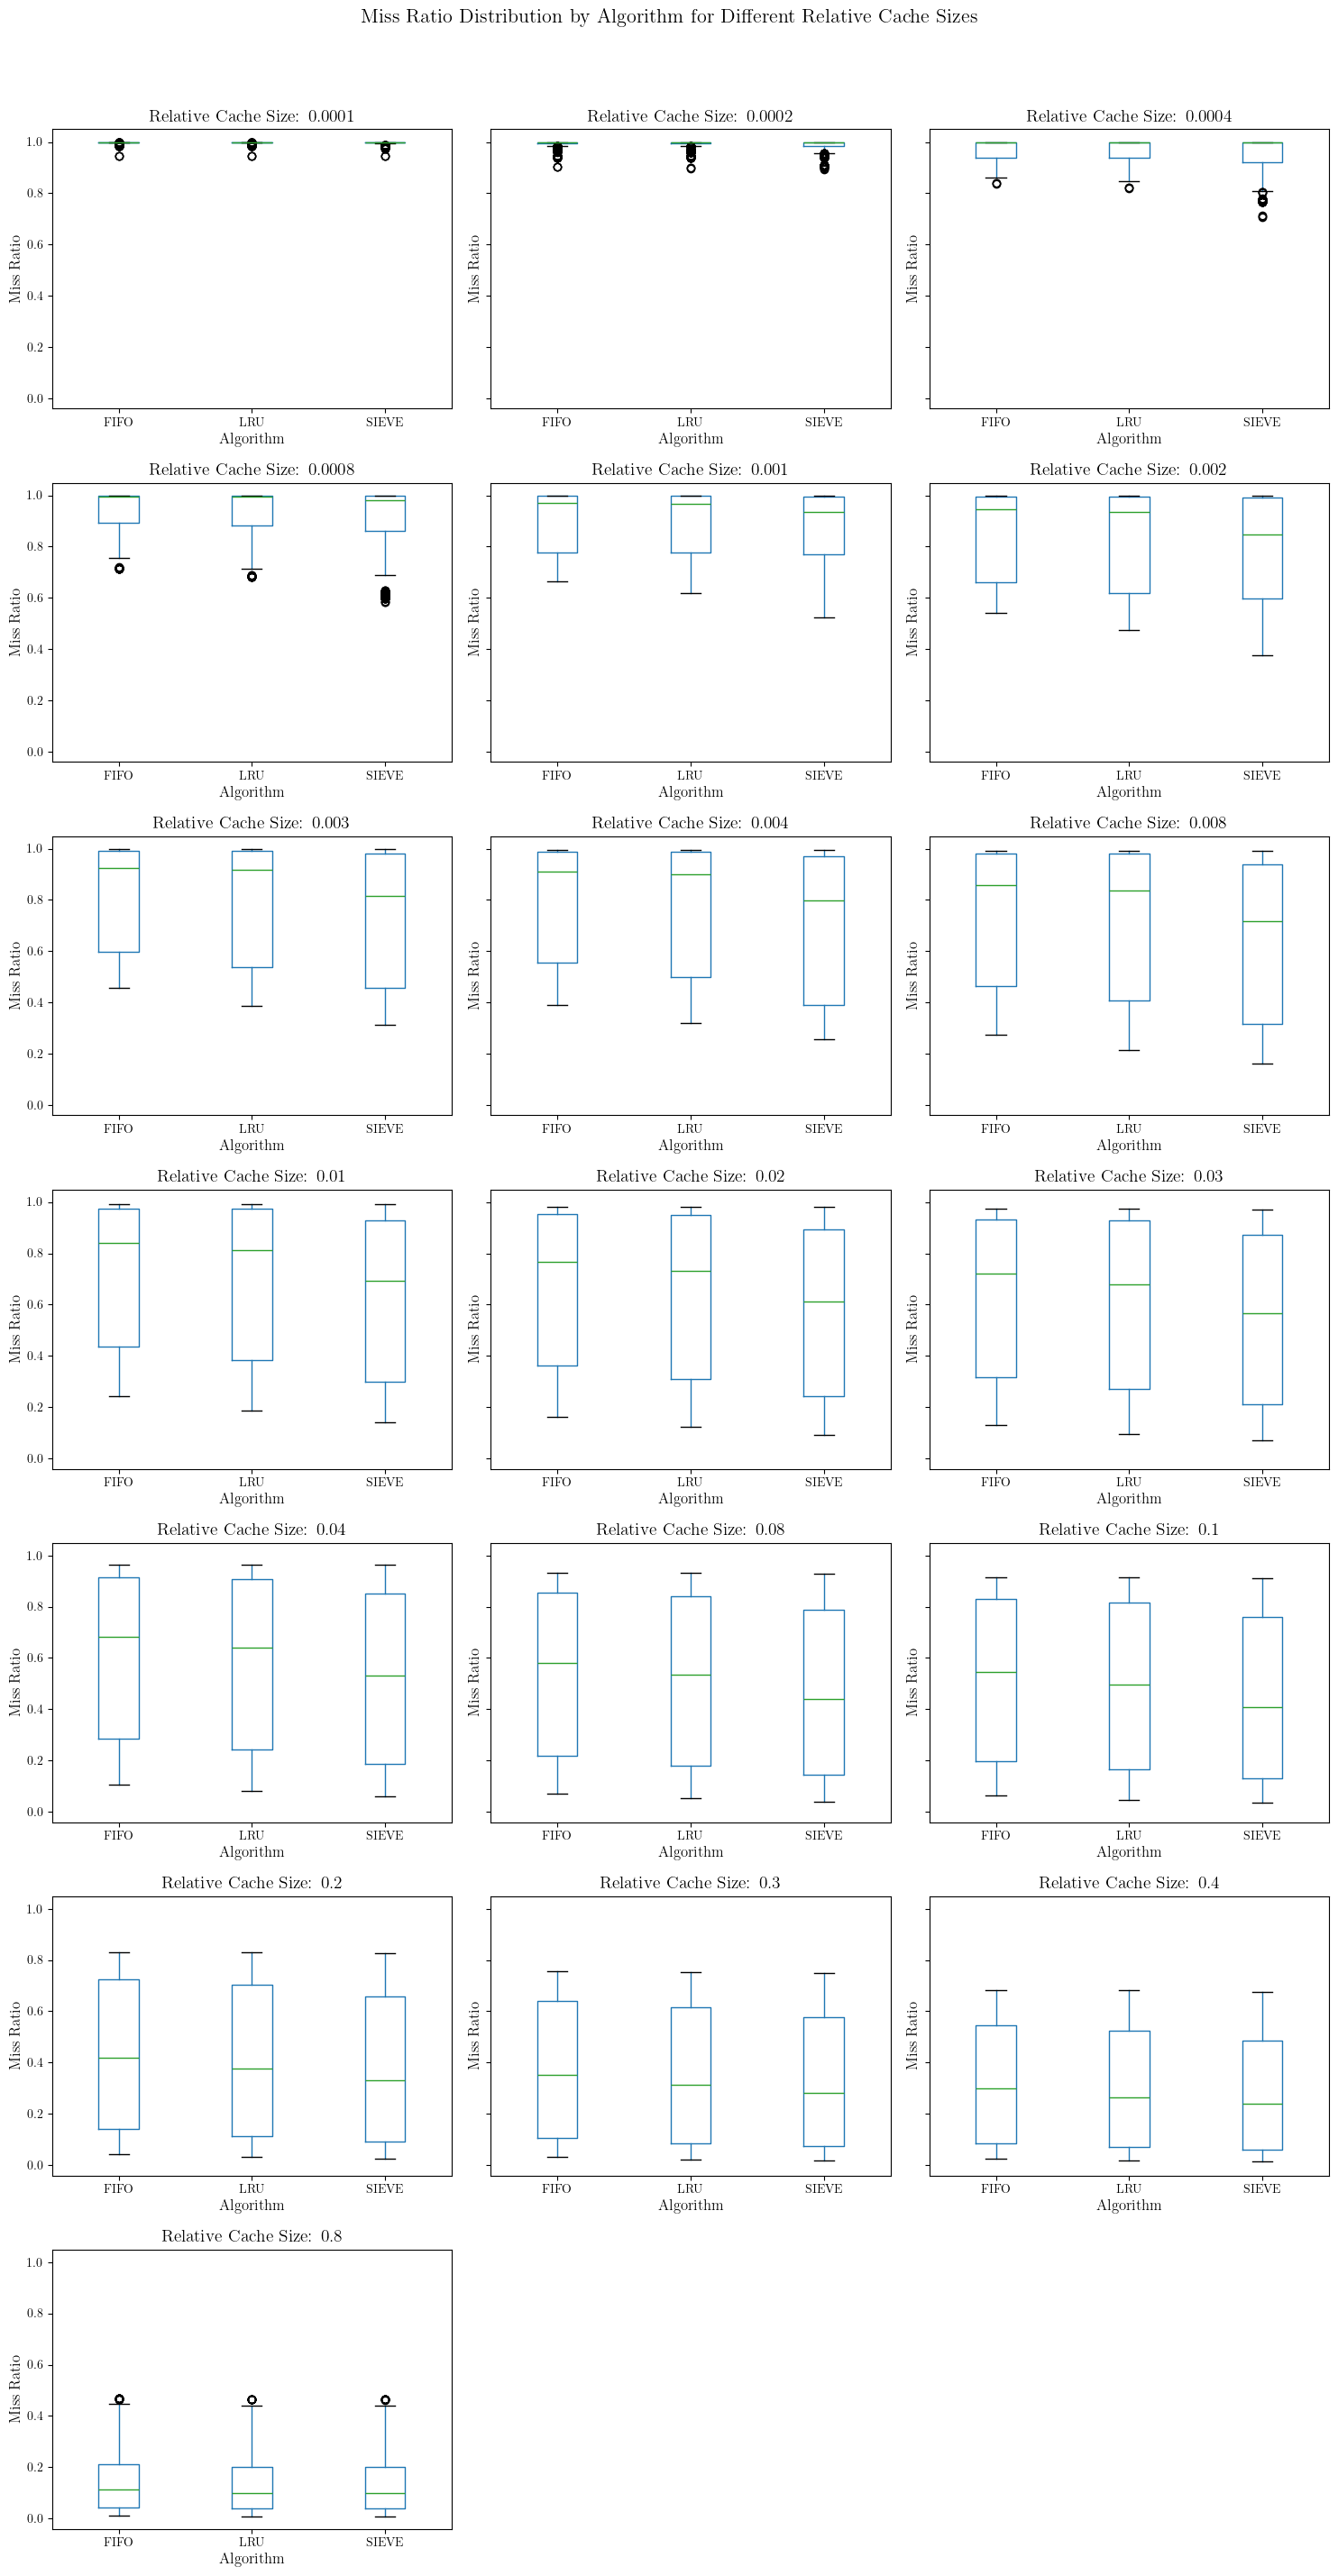

In [11]:
# Plot miss ratio distribution per algorithm for each relative cache size using boxplots and violin plots
unique_sizes = sorted(results_df['cache_size_relative_rounded'].unique())
n_sizes = len(unique_sizes)
n_cols = 3
n_rows = (n_sizes + n_cols - 1) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows), sharey=True)
axs = axs.flatten()

for i, size in enumerate(unique_sizes):
    subset = results_df[results_df['cache_size_relative_rounded'] == size]
    ax = axs[i]
    subset.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
    ax.set_title(f'Relative Cache Size: {size}')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.suptitle('Miss Ratio Distribution by Algorithm for Different Relative Cache Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Line plot (linear + log)

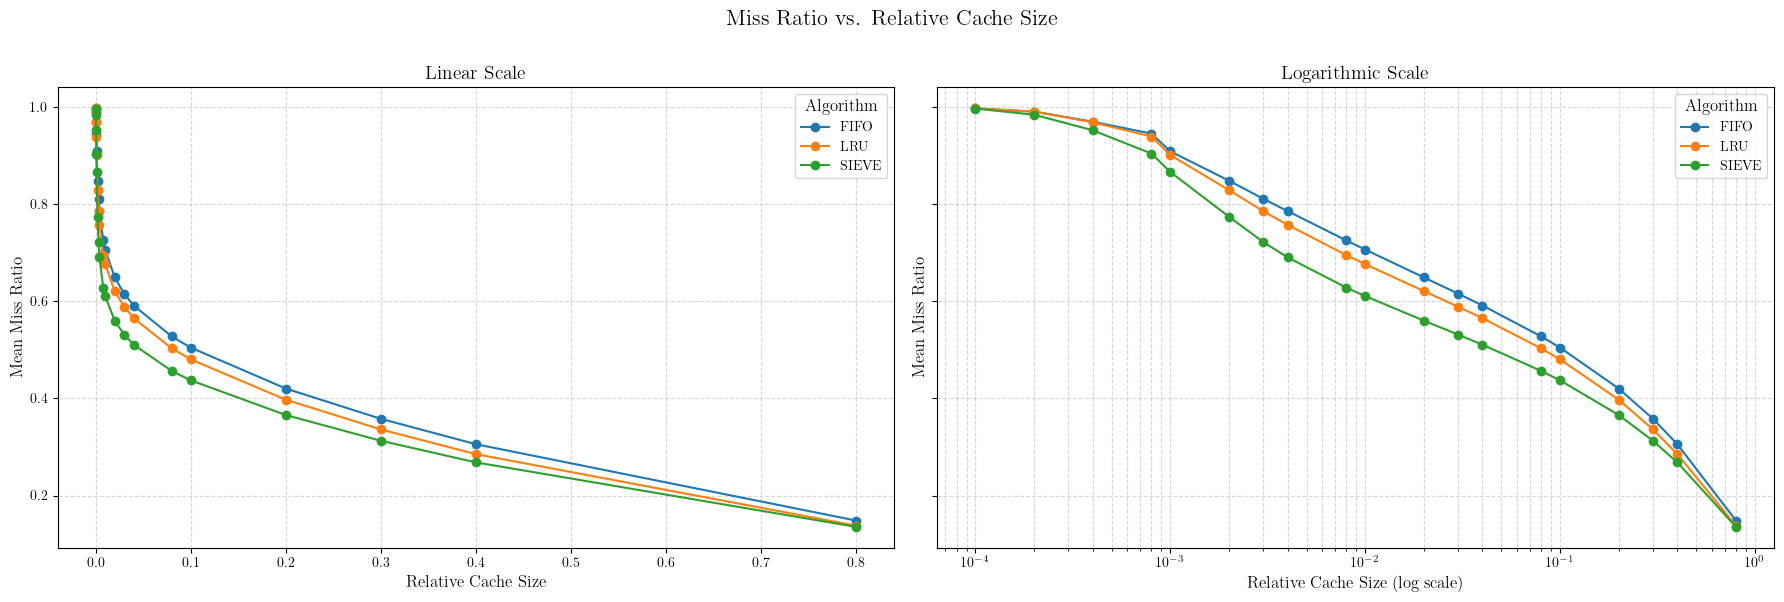

In [12]:
# Group by algorithm and cache_size_relative_rounded, aggregate mean miss ratio
agg_mean = results_df.groupby(['algorithm', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()
filenames = {"both" : "miss_ratio_vs_cache_size_both.pdf",
             "log" : "miss_ratio_vs_cache_size_log.pdf",
             "linear" : "miss_ratio_vs_cache_size_linear.pdf"}

def plot_miss_ratio_vs_cache_size_no_error(
    agg_df,
    scale='both',
    figsize=(18, 6),
    marker='o',
    save_fig=False
):
    """
    Plot miss ratio vs. relative cache size without error bars.

    Parameters:
        agg_df (pd.DataFrame): Aggregated dataframe with columns ['algorithm', 'cache_size_relative_rounded', 'miss_ratio']
        scale (str): 'linear', 'log', or 'both'
        figsize (tuple): Figure size
        marker (str): Marker style
    """
    scales = []

    if scale == 'both':
        scales = ['linear', 'log']
    else:
        scales = [scale]
        
    n_plots = len(scales)
    _, axs = plt.subplots(1, n_plots, figsize=figsize,
                          sharey=True if n_plots > 1 else False)

    if n_plots == 1:
        axs = [axs]

    if scale == 'both': plt.suptitle('Miss Ratio vs. Relative Cache Size', fontsize=16, y=1)

    for i, sc in enumerate(scales):
        for algo in agg_df['algorithm'].unique():
            df_algo = agg_df[agg_df['algorithm'] == algo]
            axs[i].plot(
                df_algo['cache_size_relative_rounded'],
                df_algo['miss_ratio'],
                marker=marker,
                label=algo,
                color=ALGORITHM_COLORS.get(algo, 'black')
            )
        axs[i].set_xlabel('Relative Cache Size' +
                          (' (log scale)' if sc == 'log' else ''))
        axs[i].set_ylabel('Mean Miss Ratio')

        # Add main title above both subplots if more than one algorithm is present and both scales are plotted
        if len(agg_df['algorithm'].unique()) > 1 and n_plots > 1:
            axs[i].set_title('Logarithmic Scale' if sc == 'log' else 'Linear Scale')
        else:
            axs[i].set_title("Miss Ratio vs. Relative Cache Size" + (" (log scale)" if sc == 'log' else ""), fontsize=16)
        axs[i].grid(True, which='both', linestyle='--', alpha=0.5)

        axs[i].legend(title='Algorithm')

        if sc == 'log':
            axs[i].set_xscale('log')

    plt.tight_layout()

    if save_fig:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, filenames[scale]), bbox_inches='tight')
    plt.show()

plot_miss_ratio_vs_cache_size_no_error(agg_mean, scale='both', save_fig=False)




### Stats & tables

In [13]:
# Overview table: Mean miss ratio by algorithm and relative cache size
print("=== MEAN MISS RATIO OVERVIEW TABLE ===")
print("Mean Miss Ratio by Algorithm and Relative Cache Size")
print("=" * 70)

# Create pivot table with mean miss ratios
overview_table = results_df.pivot_table(
    values='miss_ratio', 
    index='cache_size_relative_rounded', 
    columns='algorithm', 
    aggfunc='mean'
).round(4)

# Display the table with proper formatting
print(f"{'Cache Size':<12} ", end="")
for algo in overview_table.columns:
    print(f"{algo:<10} ", end="")
print()
print("-" * 70)

for cache_size, row in overview_table.iterrows():
    print(f"{cache_size:<12.4f} ", end="")
    for algo in overview_table.columns:
        value = row[algo]
        if pd.isna(value):
            print(f"{'N/A':<10} ", end="")
        else:
            print(f"{value:<10.4f} ", end="")
    print()

print("=" * 70)

# Summary statistics for the table
print(f"\nTABLE SUMMARY:")
print(f"Number of cache sizes: {len(overview_table.index)}")
print(f"Number of algorithms: {len(overview_table.columns)}")
print(f"Cache size range: {overview_table.index.min():.4f} - {overview_table.index.max():.4f}")

# Show overall algorithm performance ranking
print(f"\nOVERALL ALGORITHM RANKING (by mean miss ratio):")
overall_means = overview_table.mean().sort_values()
print(f"{'Rank':<6} {'Algorithm':<12} {'Mean Miss Ratio':<16}")
print("-" * 35)
for rank, (algo, mean_miss) in enumerate(overall_means.items(), 1):
    print(f"{rank:<6} {algo:<12} {mean_miss:<16.4f}")

print(f"\n" + "=" * 70)

=== MEAN MISS RATIO OVERVIEW TABLE ===
Mean Miss Ratio by Algorithm and Relative Cache Size
Cache Size   FIFO       LRU        SIEVE      
----------------------------------------------------------------------
0.0001       0.9976     0.9976     0.9971     
0.0002       0.9910     0.9909     0.9846     
0.0004       0.9701     0.9689     0.9525     
0.0008       0.9457     0.9397     0.9045     
0.0010       0.9091     0.9014     0.8665     
0.0020       0.8487     0.8293     0.7744     
0.0030       0.8114     0.7858     0.7223     
0.0040       0.7860     0.7576     0.6906     
0.0080       0.7256     0.6953     0.6284     
0.0100       0.7067     0.6767     0.6110     
0.0200       0.6494     0.6212     0.5603     
0.0300       0.6159     0.5889     0.5316     
0.0400       0.5915     0.5653     0.5107     
0.0800       0.5278     0.5032     0.4568     
0.1000       0.5048     0.4806     0.4374     
0.2000       0.4205     0.3975     0.3659     
0.3000       0.3581     0.3362     0.3

## Miss ratio vs. alpha

### Line plot

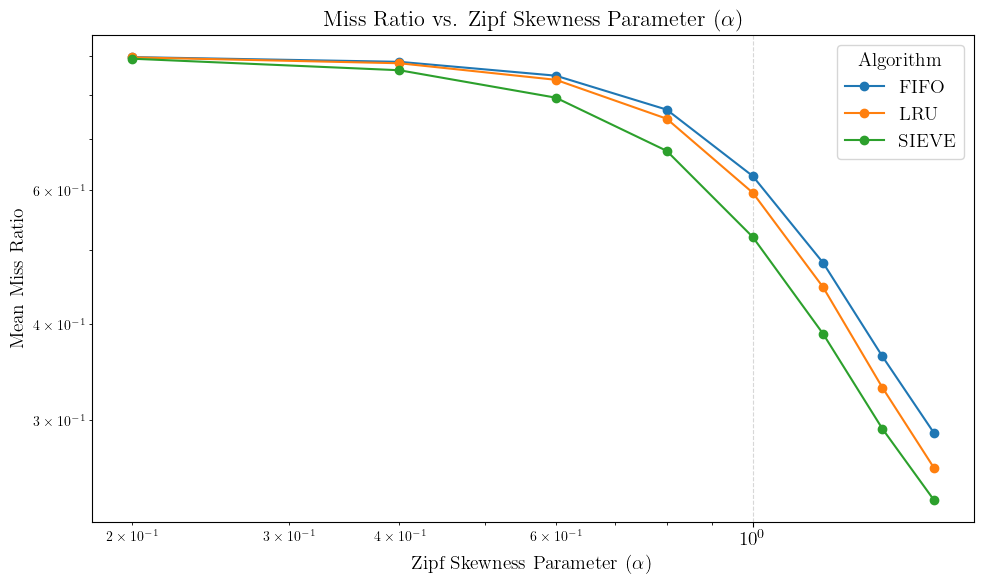

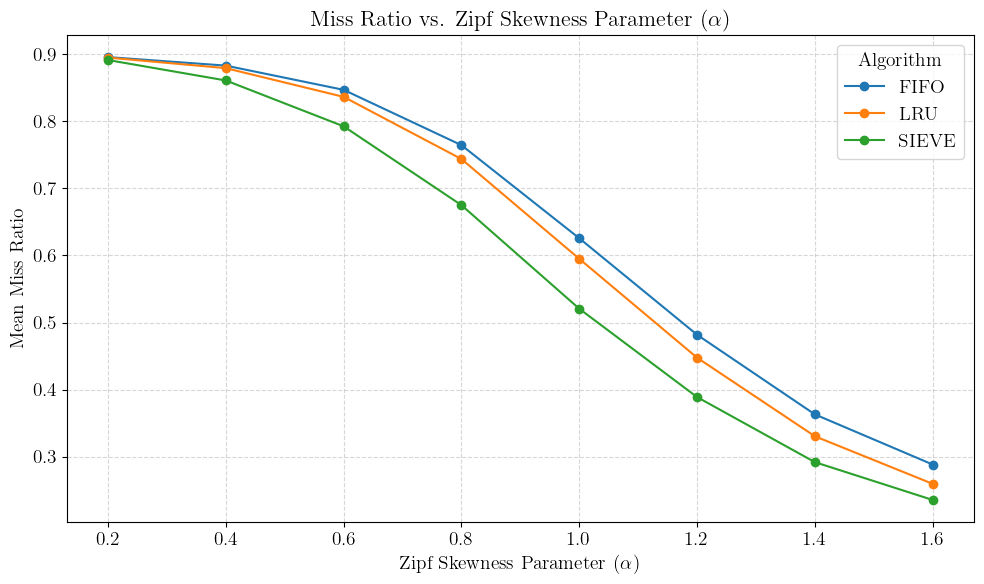

In [18]:
def plot_miss_ratio_vs_alpha(save=False, title=True, log=False):
    # Aggregate mean miss ratio by algorithm and alpha
    zipf_agg = results_df.groupby(['algorithm', 'alpha'])['miss_ratio'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    for algo in zipf_agg['algorithm'].unique():
        df_algo = zipf_agg[zipf_agg['algorithm'] == algo]
        plt.plot(df_algo['alpha'], df_algo['miss_ratio'], 
                marker='o', label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))

    plt.xlabel(r'Zipf Skewness Parameter ($\alpha$)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)

    if log:
        plt.xscale('log')
        plt.yscale('log')

    if title: plt.title(r'Miss Ratio vs. Zipf Skewness Parameter ($\alpha$)', fontsize=TITLE_FONT_SIZE)
    plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save: plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_vs_alpha{'_log' if log else ''}{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')
    plt.show()

plot_miss_ratio_vs_alpha(save=False, title=True, log=True)
plot_miss_ratio_vs_alpha(save=False, title=True, log=False)

### Statistics

In [19]:
# Aggregate mean miss ratio by algorithm and alpha
zipf_agg = results_df.groupby(['algorithm', 'alpha'])['miss_ratio'].mean().reset_index()

# Print statistics for mean miss ratio by algorithm and alpha
print("Mean Miss Ratio by Algorithm and Alpha:")
print("=" * 50)

# Create a pivot table for better readability
pivot_table = zipf_agg.pivot(index='alpha', columns='algorithm', values='miss_ratio')
print(pivot_table.round(4))

# Calculate percentage advantages
sieve_vs_fifo = ((pivot_table['FIFO'] - pivot_table['SIEVE']) / pivot_table['FIFO'] * 100)
sieve_vs_lru = ((pivot_table['LRU'] - pivot_table['SIEVE']) / pivot_table['LRU'] * 100)

# Print summary statistics
print("\nSIEVE Percentage Advantage Summary:")
print("=" * 50)
print(f"{'Alpha':<8} {'vs FIFO (%)':<12} {'vs LRU (%)':<12}")
print("-" * 50)

for alpha in sorted(pivot_table.index):
    fifo_adv = sieve_vs_fifo[alpha]
    lru_adv = sieve_vs_lru[alpha]
    print(f"{alpha:<8.1f} {fifo_adv:<12.2f} {lru_adv:<12.2f}")

# Calculate absolute performance differences
sieve_vs_fifo_abs = pivot_table['FIFO'] - pivot_table['SIEVE']
sieve_vs_lru_abs = pivot_table['LRU'] - pivot_table['SIEVE']

# Print absolute performance differences
print("\nSIEVE Absolute Performance Difference (Miss Ratio):")
print("=" * 60)
print(f"{'Alpha':<8} {'vs FIFO':<12} {'vs LRU':<12} {'SIEVE':<12}")
print("-" * 60)

for alpha in sorted(pivot_table.index):
    fifo_diff = sieve_vs_fifo_abs[alpha]
    lru_diff = sieve_vs_lru_abs[alpha]
    sieve_miss = pivot_table.loc[alpha, 'SIEVE']
    print(f"{alpha:<8.1f} {fifo_diff:<12.4f} {lru_diff:<12.4f} {sieve_miss:<12.4f}")

print(f"\nNote: Positive values indicate SIEVE performs better (lower miss ratio)")

# ===== SAVE COMPREHENSIVE COMPARISON TABLE TO CSV =====

comprehensive_df = pd.DataFrame({
    'alpha': sorted(pivot_table.index),
    'fifo_miss_ratio': [pivot_table.loc[alpha, 'FIFO'] for alpha in sorted(pivot_table.index)],
    'lru_miss_ratio': [pivot_table.loc[alpha, 'LRU'] for alpha in sorted(pivot_table.index)],
    'sieve_miss_ratio': [pivot_table.loc[alpha, 'SIEVE'] for alpha in sorted(pivot_table.index)],
    'sieve_vs_fifo_percent': [sieve_vs_fifo[alpha] for alpha in sorted(pivot_table.index)],
    'sieve_vs_lru_percent': [sieve_vs_lru[alpha] for alpha in sorted(pivot_table.index)],
    'sieve_vs_fifo_absolute': [sieve_vs_fifo_abs[alpha] for alpha in sorted(pivot_table.index)],
    'sieve_vs_lru_absolute': [sieve_vs_lru_abs[alpha] for alpha in sorted(pivot_table.index)]
}).round(4)
comprehensive_df.to_csv(os.path.join(TABLES_DIR, 'mean_miss_ratio_by_algorithm_alpha.csv'), index=False)

Mean Miss Ratio by Algorithm and Alpha:
algorithm    FIFO     LRU   SIEVE
alpha                            
0.2        0.8959  0.8951  0.8915
0.4        0.8832  0.8794  0.8610
0.6        0.8470  0.8365  0.7926
0.8        0.7645  0.7438  0.6751
1.0        0.6257  0.5950  0.5206
1.2        0.4817  0.4475  0.3888
1.4        0.3630  0.3304  0.2918
1.6        0.2882  0.2594  0.2354

SIEVE Percentage Advantage Summary:
Alpha    vs FIFO (%)  vs LRU (%)  
--------------------------------------------------
0.2      0.49         0.41        
0.4      2.51         2.09        
0.6      6.42         5.25        
0.8      11.70        9.24        
1.0      16.80        12.51       
1.2      19.29        13.12       
1.4      19.62        11.69       
1.6      18.33        9.26        

SIEVE Absolute Performance Difference (Miss Ratio):
Alpha    vs FIFO      vs LRU       SIEVE       
------------------------------------------------------------
0.2      0.0044       0.0037       0.8915      
0.4    

### SIEVE advantage plot

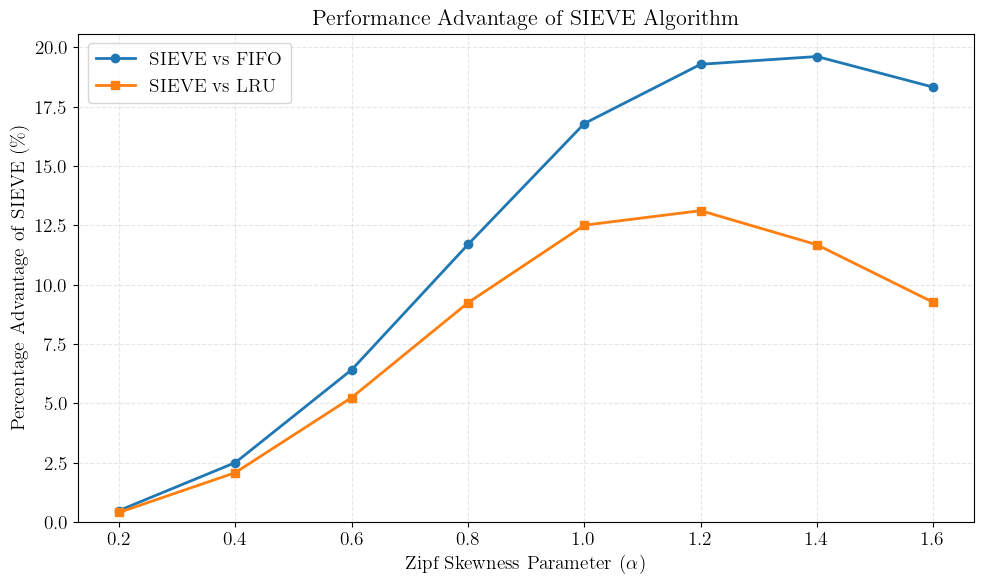

In [20]:
def plot_sieve_advantage(save=False, title=True):
    """
    Plot the percentage advantage of SIEVE compared to FIFO and LRU algorithms.
    Percentage advantage = (baseline_miss_ratio - sieve_miss_ratio) / baseline_miss_ratio * 100
    """
    # Use the already computed zipf_agg data
    pivot_data = zipf_agg.pivot(index='alpha', columns='algorithm', values='miss_ratio')
    
    # Calculate percentage advantages
    sieve_vs_fifo = ((pivot_data['FIFO'] - pivot_data['SIEVE']) / pivot_data['FIFO'] * 100)
    sieve_vs_lru = ((pivot_data['LRU'] - pivot_data['SIEVE']) / pivot_data['LRU'] * 100)
    
    plt.figure(figsize=(10, 6))
    
    # Plot percentage advantages
    plt.plot(pivot_data.index, sieve_vs_fifo, marker='o', linewidth=2, 
             label='SIEVE vs FIFO', color=FIFO_COLOR, markersize=6)
    plt.plot(pivot_data.index, sieve_vs_lru, marker='s', linewidth=2, 
             label='SIEVE vs LRU', color=LRU_COLOR, markersize=6)
    
    plt.xlabel(r'Zipf Skewness Parameter ($\alpha$)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Percentage Advantage of SIEVE (\%)', fontsize=AXIS_FONT_SIZE)

    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    
    # Set y-axis to start at 0
    plt.ylim(bottom=0)
    
    if title:
        plt.title('Performance Advantage of SIEVE Algorithm', fontsize=TITLE_FONT_SIZE)
    
    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"sieve_advantage{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')
    
    plt.show()

plot_sieve_advantage(save=False, title=True)

## Miss ratio vs. alpha + relative cache size

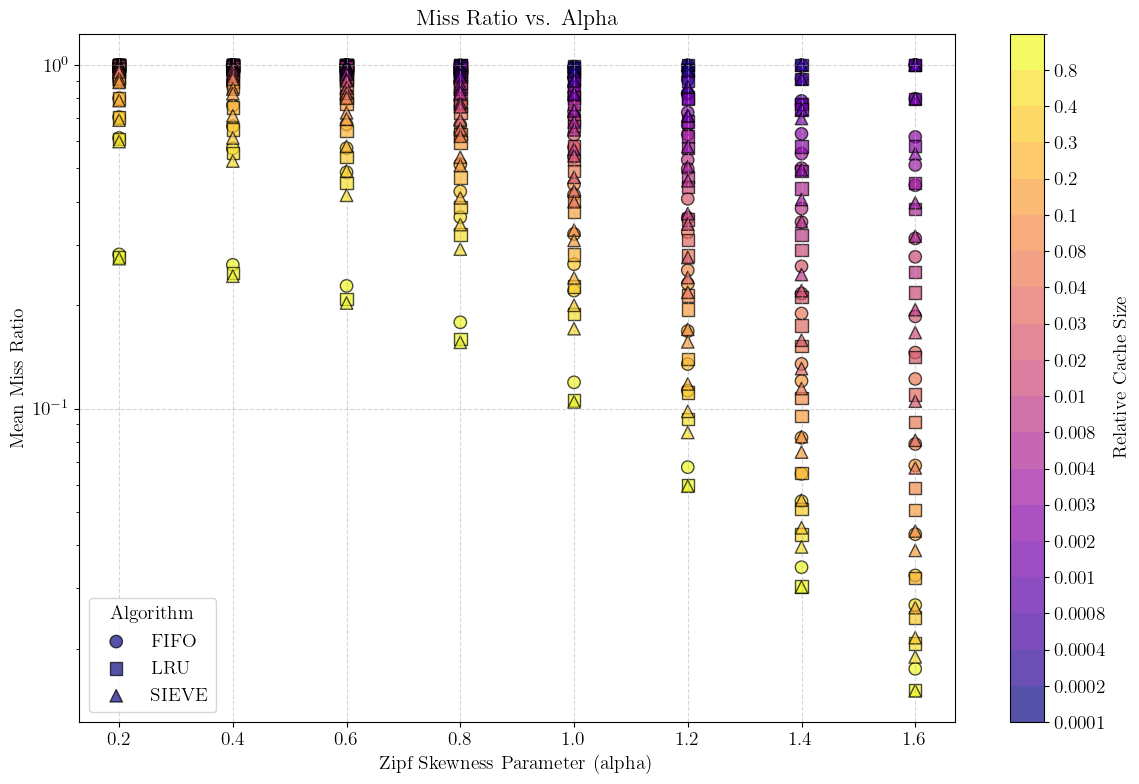

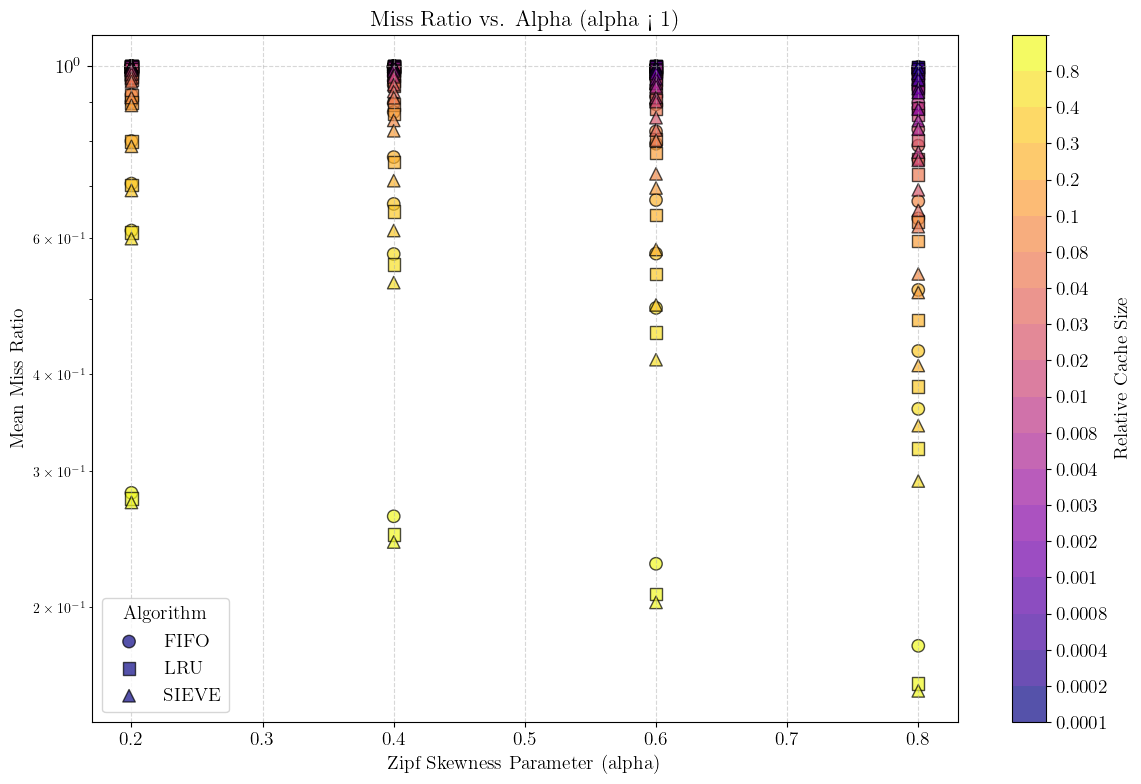

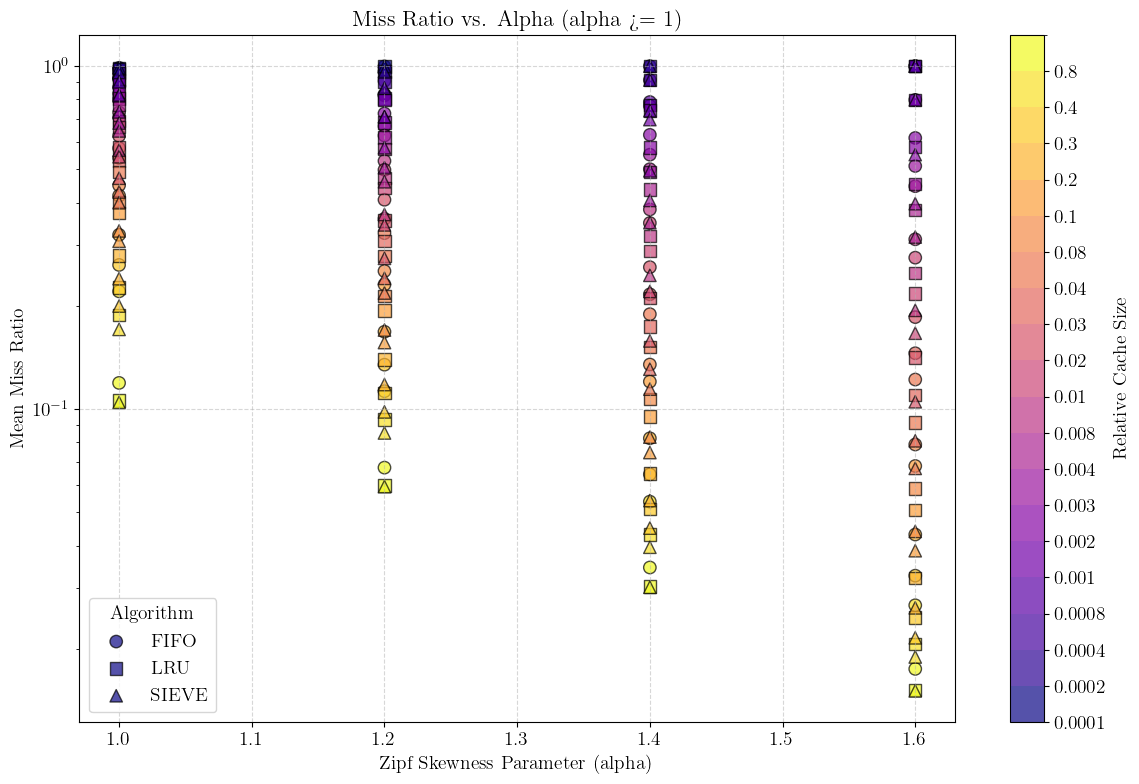

In [21]:
# Pivot the data to have (alpha, cache_size_relative_rounded) as x, algorithm as lines
pivot_df = results_df.groupby(['algorithm', 'alpha', 'cache_size_relative_rounded'])['miss_ratio'].mean().reset_index()

# Assign a unique marker for each algorithm
markers = {
    'FIFO': 'o',
    'LRU': 's', 
    'SIEVE': '^'
}

cmap = 'plasma'

# Only use the specified relative cache sizes
relevant_sizes = sorted(pivot_df['cache_size_relative_rounded'].unique())
filtered_df = pivot_df[pivot_df['cache_size_relative_rounded'].isin(relevant_sizes)]

# # Create a colormap and norm that matches the relevant sizes
cmap = plt.get_cmap('plasma', len(relevant_sizes))
norm = mpl.colors.BoundaryNorm(boundaries=np.append(relevant_sizes, relevant_sizes[-1]+0.001), ncolors=len(relevant_sizes))

# Split the filtered_df into two based on alpha
below_1 = filtered_df[filtered_df['alpha'] < 1]
above_eq_1 = filtered_df[filtered_df['alpha'] >= 1]

def plot_scatter(df, title=None, save=False):
    plt.figure(figsize=(12, 8))
    scs = []
    for algo in df['algorithm'].unique():
        df_algo = df[df['algorithm'] == algo]
        sc = plt.scatter(
            df_algo['alpha'],
            df_algo['miss_ratio'],
            c=df_algo['cache_size_relative_rounded'],
            cmap=cmap,
            norm=norm,
            s=80,
            alpha=0.7,
            marker=markers.get(algo, 'o'),
            label=algo,
            edgecolor='black'
        )
        scs.append(sc)
    plt.xlabel('Zipf Skewness Parameter (alpha)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)

    if title: plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.yscale('log')
    cbar = plt.colorbar(scs[0], ticks=relevant_sizes, label='Relative Cache Size')
    cbar.ax.set_yticklabels([str(s) for s in relevant_sizes])
    
    # Set colorbar font sizes
    cbar.ax.tick_params(labelsize=TICKS_FONT_SIZE)
    cbar.set_label('Relative Cache Size', fontsize=LEGEND_FONT_SIZE)
    
    plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_heat_map{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')

    plt.show()


plot_scatter(filtered_df, "Miss Ratio vs. Alpha")
plot_scatter(below_1, 'Miss Ratio vs. Alpha (alpha < 1)')
plot_scatter(above_eq_1, 'Miss Ratio vs. Alpha (alpha >= 1)')

## Miss ratio distribution

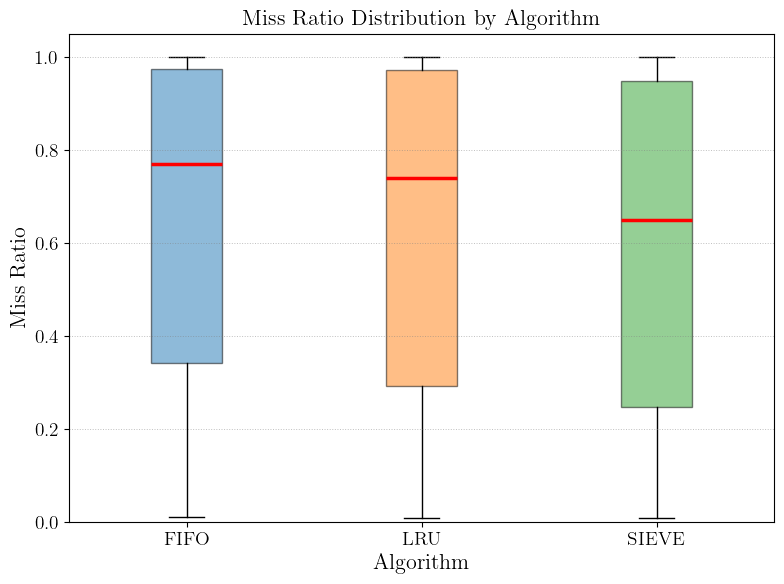

In [22]:
def plot_boxplot_miss_ratio(save=False, title=True):
    plt.figure(figsize=(8, 6))

    # Prepare data for colored boxplots
    box_data = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
    algorithms = results_df['algorithm'].unique()

    # Create boxplot with colors
    bp = plt.boxplot(box_data, labels=algorithms, patch_artist=True, medianprops=dict(color='red', linewidth=2.5))

    # Color each box with algorithm-specific colors
    for i, (patch, algo) in enumerate(zip(bp['boxes'], algorithms)):
        patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
        patch.set_alpha(0.5)

    if title: plt.title('Miss Ratio Distribution by Algorithm', fontsize=16)
    plt.xlabel('Algorithm', fontsize=16)
    plt.ylabel('Miss Ratio', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.ylim(0, 1.05)

    # Add horizontal grid lines
    ax = plt.gca()
    for y in ax.get_yticks():
        ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, f"miss_ratio_distribution{'_no_title' if not title else ''}.pdf"), bbox_inches='tight')

    plt.show()

plot_boxplot_miss_ratio(title=True, save=False)

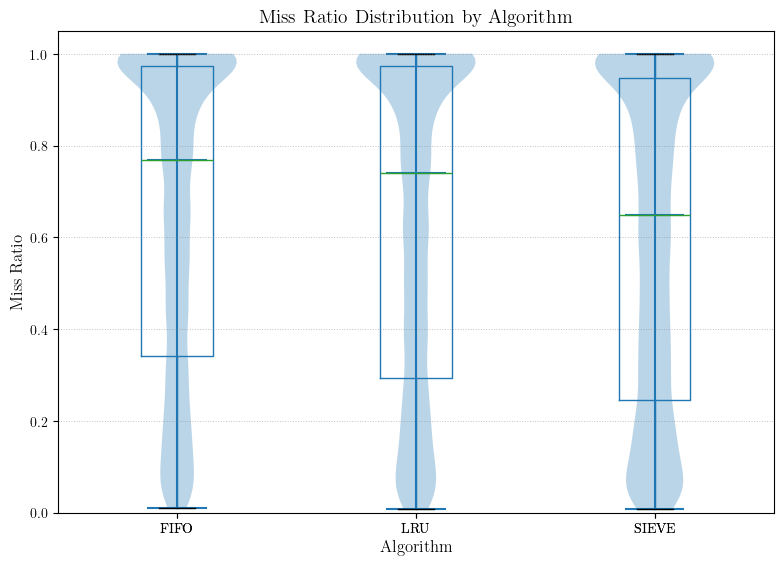

In [23]:
plt.figure(figsize=(8, 6))
subset_violin = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
plt.violinplot(subset_violin, showmeans=False, showmedians=True)
plt.xticks(range(1, len(results_df['algorithm'].unique()) + 1), results_df['algorithm'].unique())
ax = plt.gca()
results_df.boxplot(column='miss_ratio', by='algorithm', ax=ax, grid=False)
plt.title('Miss Ratio Distribution by Algorithm')
plt.suptitle('')
plt.xlabel('Algorithm')
plt.ylabel('Miss Ratio')
plt.tight_layout()
ax.set_ylim(0, 1.05)

for y in ax.get_yticks():
    ax.axhline(y, color='gray', linestyle=':', linewidth=0.7, alpha=0.5)

plt.show()

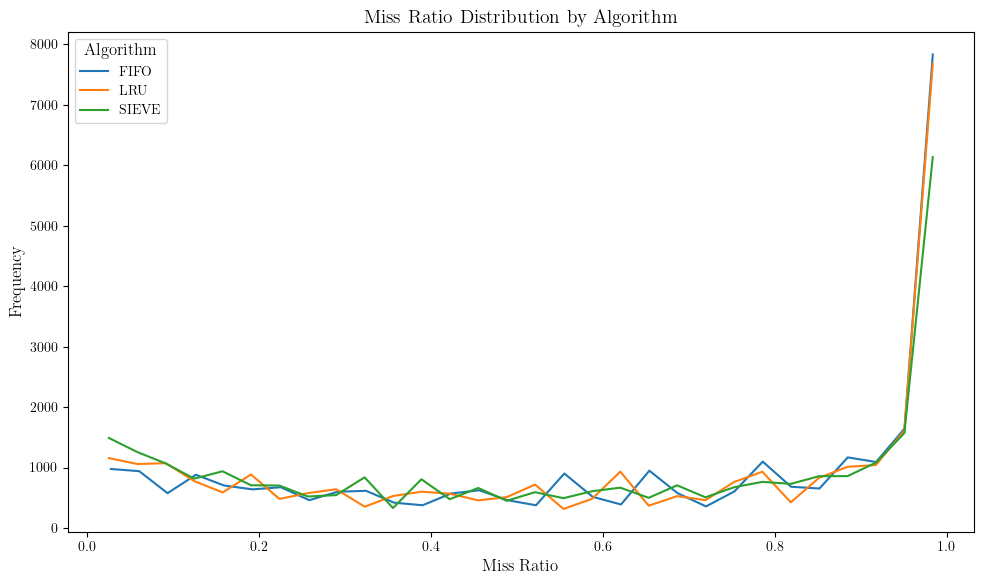

In [24]:
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, bin_edges = np.histogram(data, bins=30)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))
plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

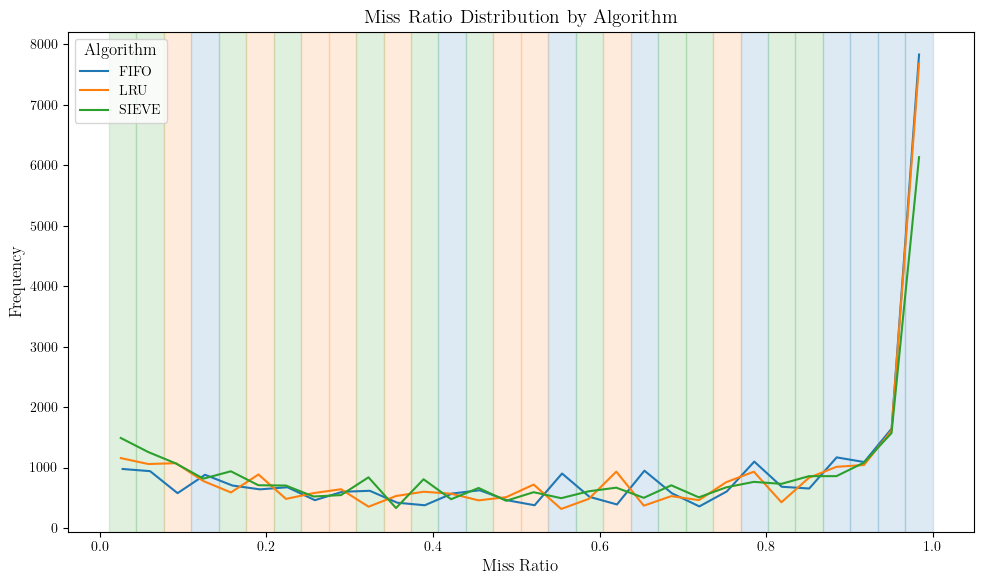

In [25]:
plt.figure(figsize=(10, 6))

# Store histogram data for each algorithm
hist_data = {}
bin_edges = None

for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    counts, edges = np.histogram(data, bins=30)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    hist_data[algo] = counts
    if bin_edges is None:
        bin_edges = edges
    plt.plot(bin_centers, counts, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'))

# Find the algorithm with the highest frequency for each bin
all_counts = np.array([hist_data[algo] for algo in results_df['algorithm'].unique()])
max_algo_idx = np.argmax(all_counts, axis=0)
algos = list(results_df['algorithm'].unique())
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(len(bin_edges) - 1):
    algo_idx = max_algo_idx[i]
    plt.axvspan(bin_edges[i], bin_edges[i+1], color=colors[algo_idx], alpha=0.15)

plt.xlabel('Miss Ratio')
plt.ylabel('Frequency')
plt.title('Miss Ratio Distribution by Algorithm')
plt.legend(title='Algorithm')
plt.tight_layout()
plt.show()

## Cumulative probability

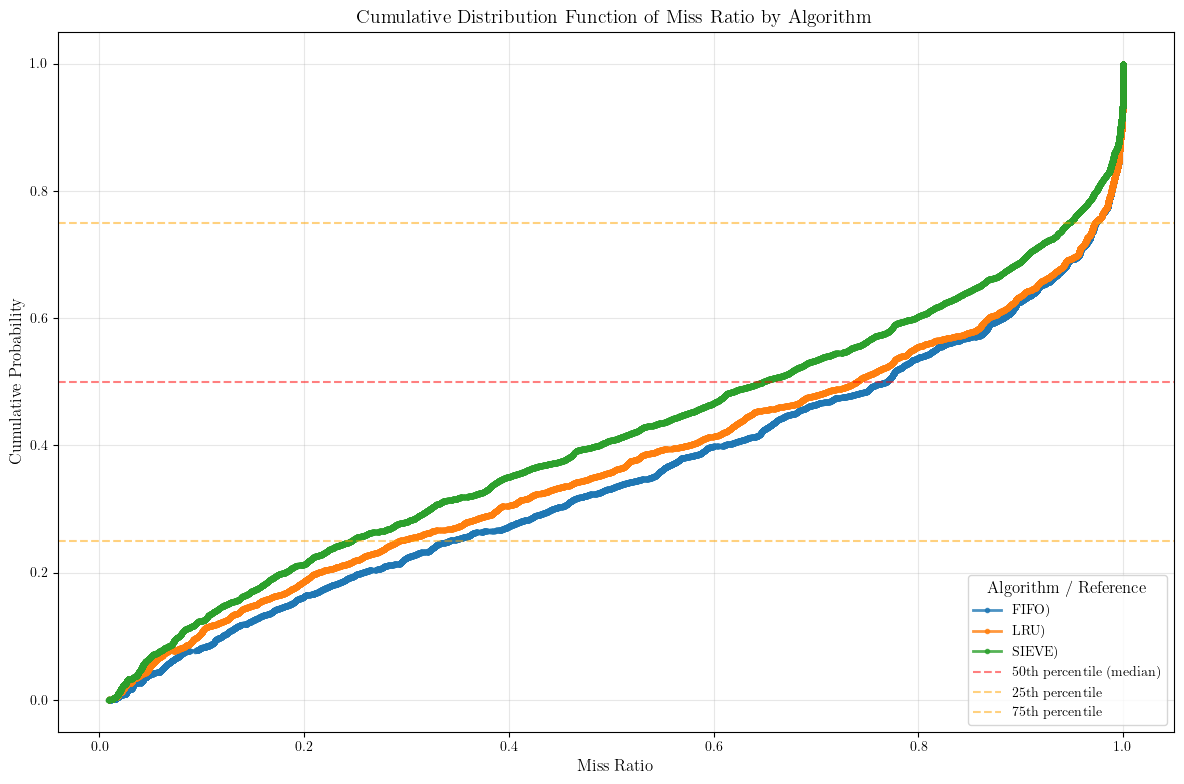

Percentile Analysis for Miss Ratio by Algorithm:
Algorithm  25th %   50th %   75th %   90th %   95th %  
------------------------------------------------------------
FIFO       0.3420   0.7688   0.9733   0.9985   0.9998  
LRU        0.2929   0.7399   0.9724   0.9985   0.9998  
SIEVE      0.2464   0.6483   0.9472   0.9973   0.9998  

Performance Comparison (Probability of Miss Ratio < 0.1):
------------------------------------------------------------
FIFO: 0.082 (8.2%)
LRU: 0.106 (10.6%)
SIEVE: 0.124 (12.4%)

Performance Comparison (Probability of Miss Ratio < 0.2):
------------------------------------------------------------
FIFO: 0.163 (16.3%)
LRU: 0.187 (18.7%)
SIEVE: 0.213 (21.3%)


In [26]:
# Cumulative probability plot for miss ratio by algorithm
plt.figure(figsize=(12, 8))

# Create cumulative probability plots for each algorithm
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    
    # Sort the data
    sorted_data = np.sort(data)
    
    # Calculate cumulative probabilities (empirical CDF)
    n = len(sorted_data)
    y = np.arange(1, n + 1) / n
    
    # Plot the CDF
    plt.plot(sorted_data, y, marker='o', markersize=3, linewidth=2, 
             label=f'{algo})', alpha=0.8, color=ALGORITHM_COLORS.get(algo, 'black'))

plt.xlabel('Miss Ratio')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Function of Miss Ratio by Algorithm')
plt.legend(title='Algorithm')
plt.grid(True, alpha=0.3)

# Add some reference lines
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50th percentile (median)')
plt.axhline(y=0.25, color='orange', linestyle='--', alpha=0.5, label='25th percentile')
plt.axhline(y=0.75, color='orange', linestyle='--', alpha=0.5, label='75th percentile')

# Update legend to include reference lines
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title='Algorithm / Reference', loc='lower right')

plt.tight_layout()
plt.show()

# Print percentile analysis
print("Percentile Analysis for Miss Ratio by Algorithm:")
print("=" * 60)
print(f"{'Algorithm':<10} {'25th %':<8} {'50th %':<8} {'75th %':<8} {'90th %':<8} {'95th %':<8}")
print("-" * 60)

for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    p25 = np.percentile(data, 25)
    p50 = np.percentile(data, 50)  # median
    p75 = np.percentile(data, 75)
    p90 = np.percentile(data, 90)
    p95 = np.percentile(data, 95)
    
    print(f"{algo:<10} {p25:<8.4f} {p50:<8.4f} {p75:<8.4f} {p90:<8.4f} {p95:<8.4f}")

# Performance comparison analysis
print(f"\nPerformance Comparison (Probability of Miss Ratio < 0.1):")
print("-" * 60)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    prob_low_miss = (data < 0.1).mean()
    print(f"{algo}: {prob_low_miss:.3f} ({prob_low_miss*100:.1f}%)")

print(f"\nPerformance Comparison (Probability of Miss Ratio < 0.2):")
print("-" * 60)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    prob_low_miss = (data < 0.2).mean()
    print(f"{algo}: {prob_low_miss:.3f} ({prob_low_miss*100:.1f}%)")

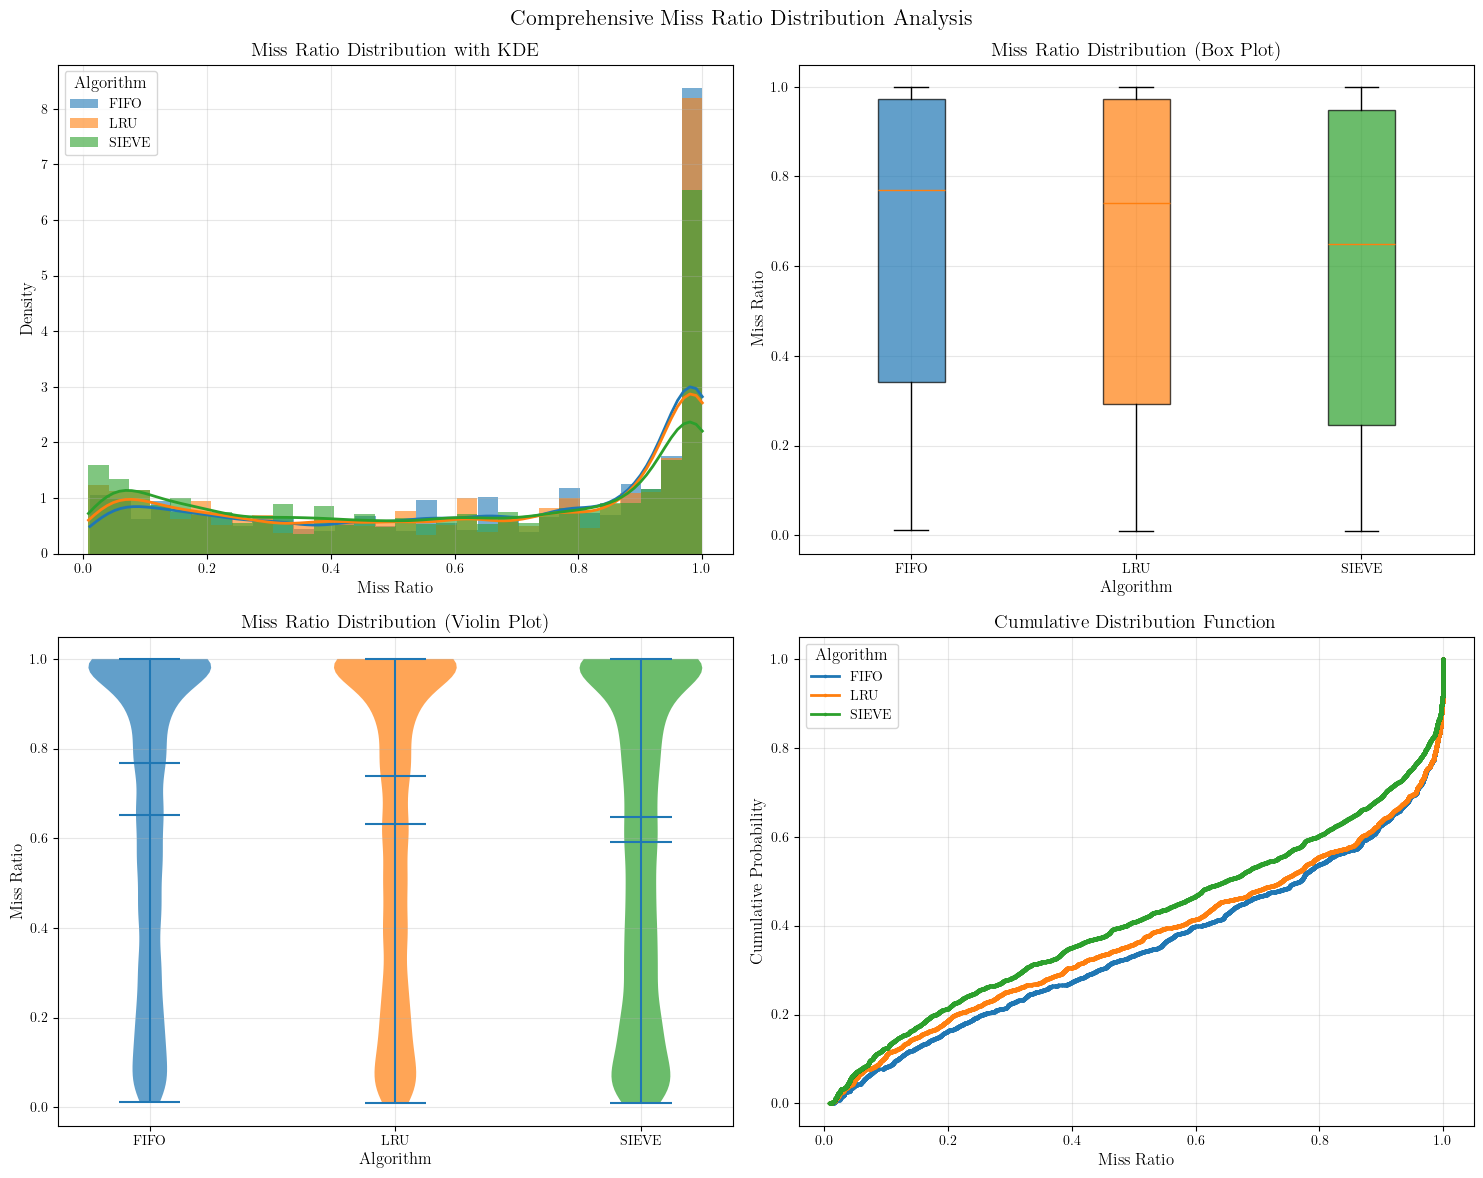

\nSummary Statistics by Algorithm:
\nFIFO:
  Mean: 0.6523
  Median: 0.7688
  Std Dev: 0.3355
  Min: 0.0111
  Max: 1.0000
  25th percentile: 0.3420
  75th percentile: 0.9733
\nLRU:
  Mean: 0.6324
  Median: 0.7399
  Std Dev: 0.3469
  Min: 0.0089
  Max: 1.0000
  25th percentile: 0.2929
  75th percentile: 0.9724
\nSIEVE:
  Mean: 0.5909
  Median: 0.6483
  Std Dev: 0.3491
  Min: 0.0088
  Max: 1.0000
  25th percentile: 0.2464
  75th percentile: 0.9472


In [27]:
# Comprehensive miss ratio distribution analysis
from scipy import stats

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Histogram with density curves
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    
    # Histogram
    ax1.hist(data, bins=30, alpha=0.6, label=algo, density=True, 
             color=ALGORITHM_COLORS.get(algo, 'gray'))
    
    # Kernel density estimation
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 100)
    ax1.plot(x_range, kde(x_range), linewidth=2, 
             color=ALGORITHM_COLORS.get(algo, 'black'))

ax1.set_xlabel('Miss Ratio')
ax1.set_ylabel('Density')
ax1.set_title('Miss Ratio Distribution with KDE')
ax1.legend(title='Algorithm')
ax1.grid(True, alpha=0.3)

# 2. Box plots
box_data = [results_df[results_df['algorithm'] == algo]['miss_ratio'] for algo in results_df['algorithm'].unique()]
bp = ax2.boxplot(box_data, labels=results_df['algorithm'].unique(), patch_artist=True)

# Color the box plots
algorithms_list = list(results_df['algorithm'].unique())
for i, (patch, algo) in enumerate(zip(bp['boxes'], algorithms_list)):
    patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
    patch.set_alpha(0.7)

ax2.set_xlabel('Algorithm')
ax2.set_ylabel('Miss Ratio')
ax2.set_title('Miss Ratio Distribution (Box Plot)')
ax2.grid(True, alpha=0.3)

# 3. Violin plots
parts = ax3.violinplot(box_data, showmeans=True, showmedians=True)
for i, (part, algo) in enumerate(zip(parts['bodies'], algorithms_list)):
    part.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
    part.set_alpha(0.7)

ax3.set_xticks(range(1, len(results_df['algorithm'].unique()) + 1))
ax3.set_xticklabels(results_df['algorithm'].unique())
ax3.set_xlabel('Algorithm')
ax3.set_ylabel('Miss Ratio')
ax3.set_title('Miss Ratio Distribution (Violin Plot)')
ax3.grid(True, alpha=0.3)

# 4. Cumulative distribution function
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax4.plot(sorted_data, y, marker='.', markersize=3, label=algo, 
             linewidth=2, color=ALGORITHM_COLORS.get(algo, 'black'))

ax4.set_xlabel('Miss Ratio')
ax4.set_ylabel('Cumulative Probability')
ax4.set_title('Cumulative Distribution Function')
ax4.legend(title='Algorithm')
ax4.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Miss Ratio Distribution Analysis', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\\nSummary Statistics by Algorithm:")
print("=" * 50)
for algo in results_df['algorithm'].unique():
    data = results_df[results_df['algorithm'] == algo]['miss_ratio']
    print(f"\\n{algo}:")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Median: {data.median():.4f}")
    print(f"  Std Dev: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  25th percentile: {data.quantile(0.25):.4f}")
    print(f"  75th percentile: {data.quantile(0.75):.4f}")

## Miss ratio vs. working set size (objects_actual)

In [28]:
# Check available columns in results_df
print("Available columns in results_df:")
print(results_df.columns.tolist())
print("\nShape of results_df:", results_df.shape)

# Check if objects_actual is available
if 'objects_actual' in results_df.columns:
    print(f"\nUnique values for objects_actual: {sorted(results_df['objects_actual'].unique())}")
    
    # Show data preview
    print(f"\nSample data with objects_actual:")
    print(results_df[['algorithm', 'objects_actual', 'miss_ratio', 'alpha']].head(10))
    
    # Check data distribution
    print(f"\nData distribution by objects_actual:")
    objects_counts = results_df['objects_actual'].value_counts().sort_index()
    print(objects_counts)
    
else:
    print("\nobjects_actual column not found in results_df")
    print("Available columns for analysis:", [col for col in results_df.columns if 'object' in col.lower()])

Available columns in results_df:
['algorithm', 'cache_size_absolute', 'cache_size_relative_rounded', 'alpha', 'objects_actual', 'objects_theoretical', 'requests', 'miss_ratio', 'file_nr']

Shape of results_df: (85113, 9)

Unique values for objects_actual: [807, 813, 819, 821, 822, 824, 826, 827, 829, 833, 835, 836, 837, 838, 853, 967, 971, 972, 973, 974, 976, 977, 978, 979, 980, 981, 984, 998, 999, 1000, 1110, 1124, 1131, 1132, 1138, 1140, 1143, 1144, 1148, 1153, 1154, 1155, 1157, 1158, 1160, 1167, 1168, 1176, 1272, 1283, 1285, 1288, 1289, 1291, 1299, 1302, 1303, 1304, 1306, 1312, 1314, 1319, 1320, 1323, 1332, 1335, 1347, 1360, 1361, 1363, 1371, 1374, 1382, 1388, 1389, 1393, 1395, 1397, 1400, 1402, 1409, 1412, 1414, 1419, 1421, 1429, 1436, 1441, 1442, 1443, 1445, 1451, 1456, 1457, 1458, 1459, 1467, 1470, 1485, 1487, 1494, 1497, 1505, 1558, 1568, 1570, 1573, 1574, 1576, 1582, 1584, 1586, 1589, 1596, 1601, 1603, 1605, 1611, 1620, 1632, 1634, 1637, 1641, 1643, 1647, 1650, 1655, 1661, 1666

In [31]:
def plot_miss_ratio_vs_working_set_size(save=False, title=True, log_scale=False):
    """
    Plot miss ratio vs. working set size (objects_actual) for each algorithm.
    
    Parameters:
        save (bool): Whether to save the plot
        title (bool): Whether to include title
        log_scale (bool): Whether to use log scale for x-axis
    """
    # Aggregate mean miss ratio by algorithm and objects_actual
    agg_working_set = results_df.groupby(['algorithm', 'objects_actual'])['miss_ratio'].agg(['mean', 'std', 'count']).reset_index()
    
    plt.figure(figsize=(12, 8))
    
    # Plot each algorithm
    for algo in agg_working_set['algorithm'].unique():
        df_algo = agg_working_set[agg_working_set['algorithm'] == algo]
        
        # Plot mean miss ratio - fix column access
        plt.plot(df_algo['objects_actual'], df_algo['mean'], 
                marker='o', label=algo, color=ALGORITHM_COLORS.get(algo, 'black'),
                linewidth=2, markersize=6)
        
        # Add error bars (standard deviation) - fix column access
        plt.errorbar(df_algo['objects_actual'], df_algo['mean'],
                    yerr=df_algo['std'], 
                    color=ALGORITHM_COLORS.get(algo, 'black'),
                    alpha=0.3, capsize=3)
    
    plt.xlabel('Working Set Size (Number of Objects)', fontsize=AXIS_FONT_SIZE)
    plt.ylabel('Mean Miss Ratio', fontsize=AXIS_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    
    if log_scale:
        plt.xscale('log')
        plt.xlabel('Working Set Size (Number of Objects) - Log Scale', fontsize=AXIS_FONT_SIZE)
    
    if title:
        plt.title('Miss Ratio vs. Working Set Size by Algorithm', fontsize=TITLE_FONT_SIZE)
    
    plt.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE, title_fontsize=LEGEND_FONT_SIZE)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    if save:
        filename = f"miss_ratio_vs_working_set_size{'_log' if log_scale else ''}{'_no_title' if not title else ''}.pdf"
        plt.savefig(os.path.join(FIGURES_SIMULATIONS_DIR, filename), bbox_inches='tight')
    
    plt.show()

# Create both linear and log scale plots
print("=== MISS RATIO VS. WORKING SET SIZE ANALYSIS ===")
print()

# Linear scale
plot_miss_ratio_vs_working_set_size(save=False, title=True, log_scale=False)

# Log scale
plot_miss_ratio_vs_working_set_size(save=False, title=True, log_scale=True)

=== MISS RATIO VS. WORKING SET SIZE ANALYSIS ===



KeyError: ('miss_ratio', 'mean')

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Print detailed statistics
print("=== WORKING SET SIZE ANALYSIS STATISTICS ===")
print()

# Basic statistics by working set size
working_set_stats = results_df.groupby('objects_actual')['miss_ratio'].agg(['count', 'mean', 'std', 'min', 'max']).round(4)
print("Statistics by working set size:")
print(working_set_stats)
print()

# Statistics by algorithm and working set size
algo_working_set_stats = results_df.groupby(['algorithm', 'objects_actual'])['miss_ratio'].agg(['count', 'mean', 'std']).round(4)
print("Statistics by algorithm and working set size:")
print(algo_working_set_stats)
print()

# Create pivot table for easier comparison
pivot_working_set = results_df.pivot_table(
    values='miss_ratio', 
    index='objects_actual', 
    columns='algorithm', 
    aggfunc='mean'
).round(4)

print("Mean miss ratio by working set size and algorithm:")
print(pivot_working_set)
print()

# Calculate performance differences
if 'SIEVE' in pivot_working_set.columns:
    sieve_vs_fifo_working = ((pivot_working_set['FIFO'] - pivot_working_set['SIEVE']) / pivot_working_set['FIFO'] * 100)
    sieve_vs_lru_working = ((pivot_working_set['LRU'] - pivot_working_set['SIEVE']) / pivot_working_set['LRU'] * 100)
    
    print("SIEVE Performance Advantage by Working Set Size:")
    print("=" * 60)
    print(f"{'Objects':<10} {'vs FIFO (%)':<12} {'vs LRU (%)':<12}")
    print("-" * 60)
    
    for objects in sorted(pivot_working_set.index):
        if not pd.isna(sieve_vs_fifo_working[objects]) and not pd.isna(sieve_vs_lru_working[objects]):
            print(f"{objects:<10} {sieve_vs_fifo_working[objects]:<12.2f} {sieve_vs_lru_working[objects]:<12.2f}")
    print()

# Save the working set analysis table
working_set_comparison = pd.DataFrame({
    'objects_actual': sorted(pivot_working_set.index),
    'fifo_miss_ratio': [pivot_working_set.loc[obj, 'FIFO'] for obj in sorted(pivot_working_set.index)],
    'lru_miss_ratio': [pivot_working_set.loc[obj, 'LRU'] for obj in sorted(pivot_working_set.index)],
    'sieve_miss_ratio': [pivot_working_set.loc[obj, 'SIEVE'] for obj in sorted(pivot_working_set.index)]
}).round(4)

if 'SIEVE' in pivot_working_set.columns:
    working_set_comparison['sieve_vs_fifo_percent'] = [sieve_vs_fifo_working[obj] for obj in sorted(pivot_working_set.index)]
    working_set_comparison['sieve_vs_lru_percent'] = [sieve_vs_lru_working[obj] for obj in sorted(pivot_working_set.index)]

working_set_comparison.to_csv(os.path.join(TABLES_DIR, 'miss_ratio_by_working_set_size.csv'), index=False)
print(f"✓ Saved working set analysis to: {os.path.join(TABLES_DIR, 'miss_ratio_by_working_set_size.csv')}")

=== WORKING SET SIZE ANALYSIS STATISTICS ===

Statistics by working set size:
                count    mean     std     min     max
objects_actual                                       
807                84  0.2977  0.3060  0.0088  1.0000
813                42  0.2958  0.3068  0.0089  1.0000
819                84  0.2980  0.3059  0.0090  1.0000
821                84  0.2977  0.3059  0.0088  1.0000
822                42  0.2973  0.3077  0.0090  1.0000
...               ...     ...     ...     ...     ...
42686              57  0.9184  0.1411  0.4644  1.0000
42688              57  0.9183  0.1410  0.4646  0.9999
42718              57  0.9180  0.1412  0.4651  0.9999
42724              57  0.9180  0.1412  0.4645  0.9999
42726              57  0.9184  0.1409  0.4647  1.0000

[995 rows x 5 columns]

Statistics by algorithm and working set size:
                          count    mean     std
algorithm objects_actual                       
FIFO      807                28  0.3253  0.3066
     

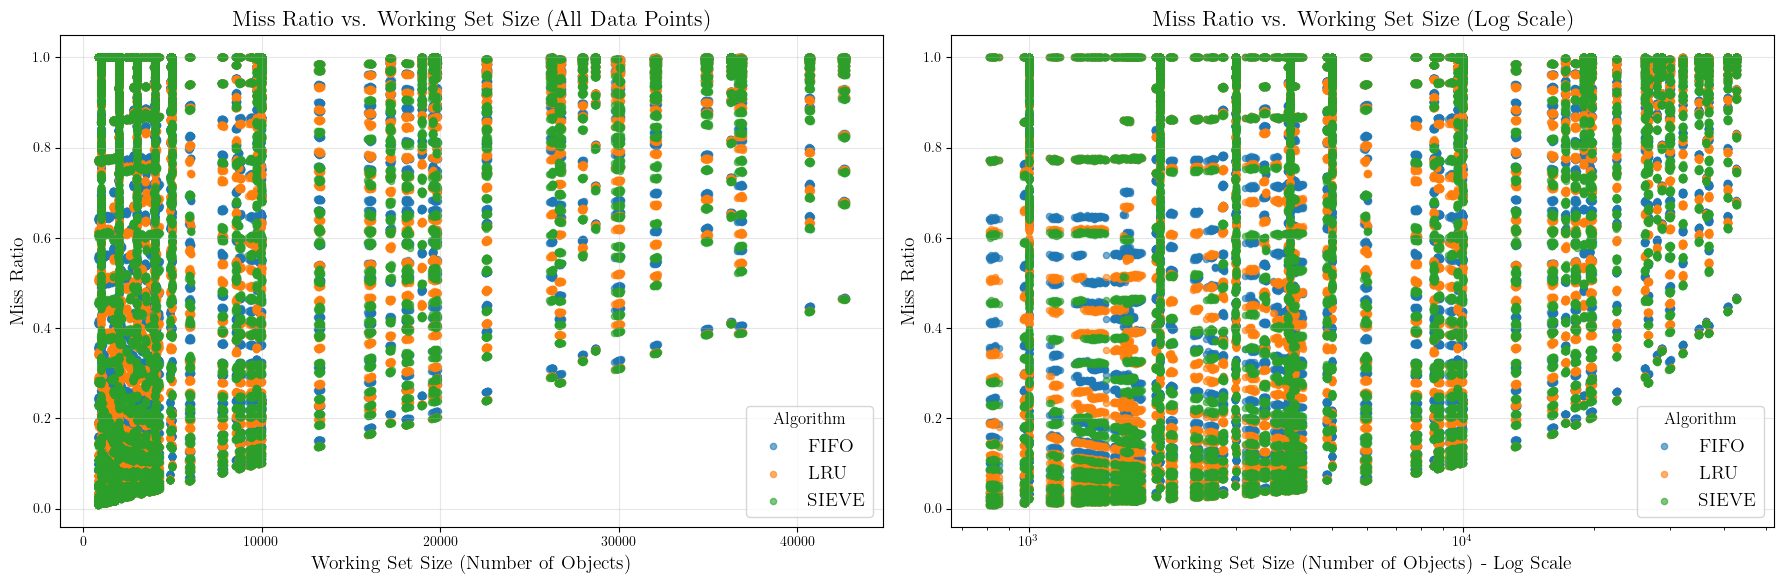


Creating box plots for 995 different working set sizes...
Showing subset of working set sizes: [807, 2460, 8525, 19794, 42726]


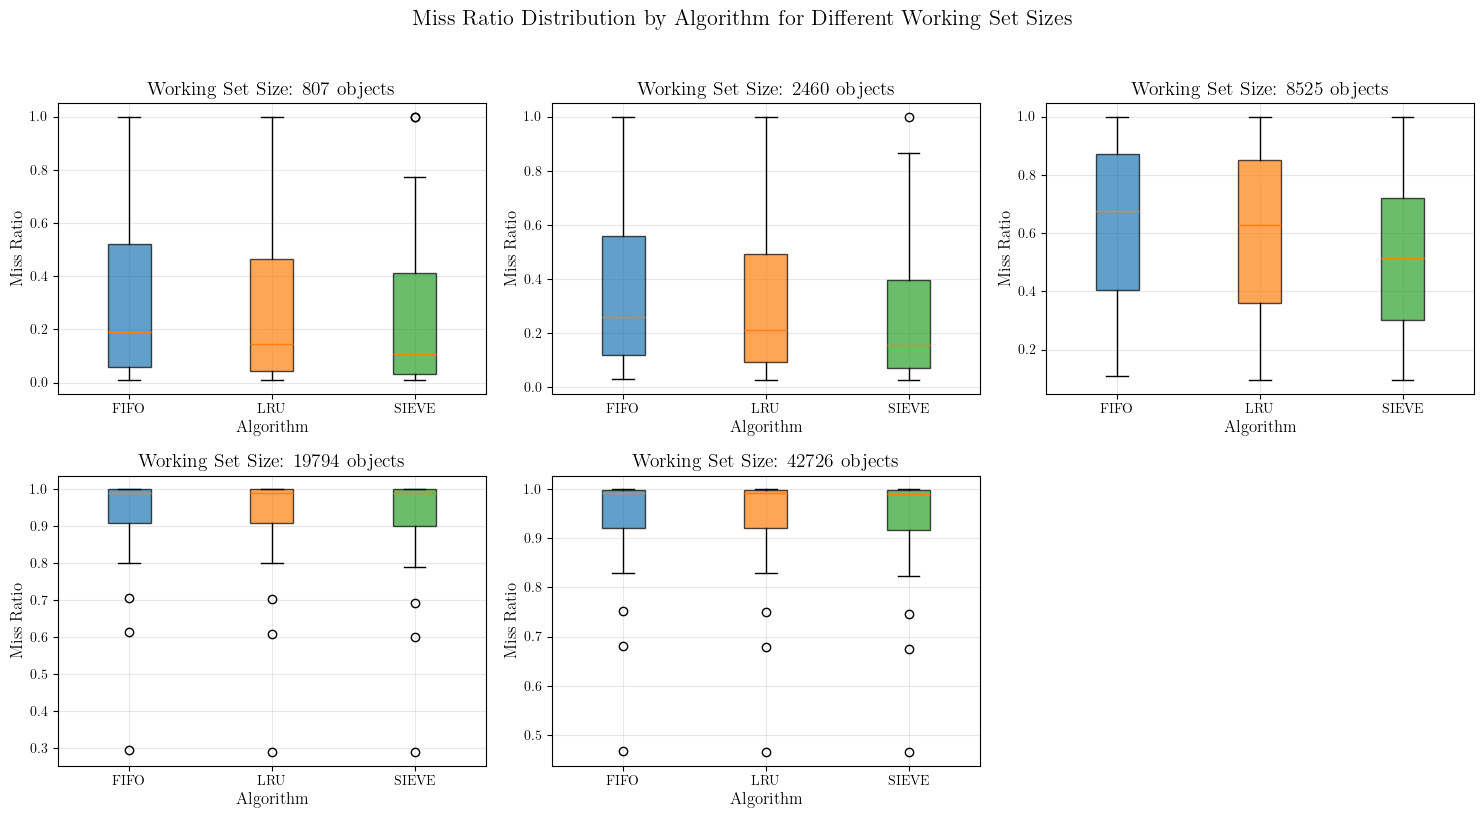

In [30]:
# Create scatter plot showing all data points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot - Linear scale
for algo in results_df['algorithm'].unique():
    df_algo = results_df[results_df['algorithm'] == algo]
    ax1.scatter(df_algo['objects_actual'], df_algo['miss_ratio'], 
               alpha=0.6, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'), s=20)

ax1.set_xlabel('Working Set Size (Number of Objects)', fontsize=AXIS_FONT_SIZE)
ax1.set_ylabel('Miss Ratio', fontsize=AXIS_FONT_SIZE)
ax1.set_title('Miss Ratio vs. Working Set Size (All Data Points)', fontsize=TITLE_FONT_SIZE)
ax1.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE)
ax1.grid(True, alpha=0.3)

# Scatter plot - Log scale
for algo in results_df['algorithm'].unique():
    df_algo = results_df[results_df['algorithm'] == algo]
    ax2.scatter(df_algo['objects_actual'], df_algo['miss_ratio'], 
               alpha=0.6, label=algo, color=ALGORITHM_COLORS.get(algo, 'black'), s=20)

ax2.set_xlabel('Working Set Size (Number of Objects) - Log Scale', fontsize=AXIS_FONT_SIZE)
ax2.set_ylabel('Miss Ratio', fontsize=AXIS_FONT_SIZE)
ax2.set_title('Miss Ratio vs. Working Set Size (Log Scale)', fontsize=TITLE_FONT_SIZE)
ax2.legend(title='Algorithm', fontsize=LEGEND_FONT_SIZE)
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

# Box plots by working set size
unique_working_sets = sorted(results_df['objects_actual'].unique())
print(f"\nCreating box plots for {len(unique_working_sets)} different working set sizes...")

# If there are too many working set sizes, show only a subset
if len(unique_working_sets) > 6:
    # Show largest, smallest, and some in between
    selected_working_sets = [
        unique_working_sets[0],  # smallest
        unique_working_sets[len(unique_working_sets)//4],  # 25th percentile
        unique_working_sets[len(unique_working_sets)//2],  # median
        unique_working_sets[3*len(unique_working_sets)//4],  # 75th percentile
        unique_working_sets[-1]  # largest
    ]
    print(f"Showing subset of working set sizes: {selected_working_sets}")
else:
    selected_working_sets = unique_working_sets

n_sets = len(selected_working_sets)
n_cols = min(3, n_sets)
n_rows = (n_sets + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
if n_sets == 1:
    axes = [axes]
elif n_rows == 1:
    axes = axes if n_cols > 1 else [axes]
else:
    axes = axes.flatten()

for i, working_set_size in enumerate(selected_working_sets):
    subset = results_df[results_df['objects_actual'] == working_set_size]
    ax = axes[i]
    
    # Create box plot data
    box_data = [subset[subset['algorithm'] == algo]['miss_ratio'] for algo in subset['algorithm'].unique()]
    bp = ax.boxplot(box_data, labels=subset['algorithm'].unique(), patch_artist=True)
    
    # Color the boxes
    for j, (patch, algo) in enumerate(zip(bp['boxes'], subset['algorithm'].unique())):
        patch.set_facecolor(ALGORITHM_COLORS.get(algo, 'gray'))
        patch.set_alpha(0.7)
    
    ax.set_title(f'Working Set Size: {working_set_size} objects')
    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Miss Ratio')
    ax.grid(True, alpha=0.3)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Miss Ratio Distribution by Algorithm for Different Working Set Sizes', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()